<a href="https://colab.research.google.com/github/Falconwatch/MarketKing/blob/main/Support_resistance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В этом ноутбуке создаётся стратегия на основе точке поддержки и сопротивления
https://medium.datadriveninvestor.com/how-to-detect-support-resistance-levels-and-breakout-using-python-f8b5dac42f21

In [2]:
#!pip install yfinance
#!pip install mplfinance

In [3]:
from numpy.core.numeric import isclose
import yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import isclose
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

In [4]:
from methods import *

# Готовим данные

In [88]:
stocks = load_data("MSFT", period_start="2021-01-01", step="1d")
stocks = stocks.reset_index()
print(stocks.shape[0])
stocks.head()

[*********************100%***********************]  1 of 1 completed
301


,Date,Open,High,Low,Close,Volume
0,2021-01-04,220.224826,220.689959,212.584796,215.434967,37130100
1,2021-01-05,215.009407,216.256364,213.465569,215.642776,23823000
2,2021-01-06,209.972142,214.247399,209.744529,210.051315,35930700
3,2021-01-07,211.822773,217.067874,211.496205,216.028748,27694500
4,2021-01-08,216.414706,218.295033,214.781804,217.344971,22956200


## Размечаем таргет

Размечаем таргет...


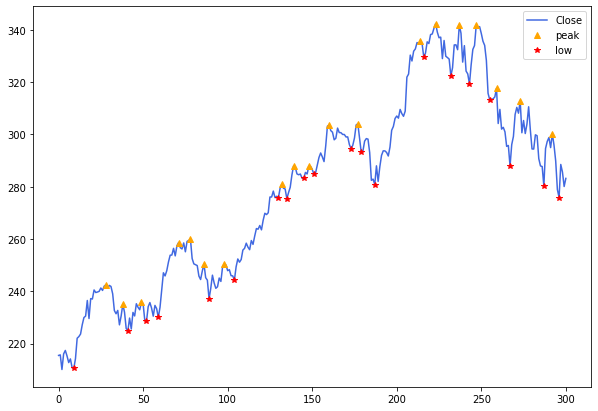

In [89]:
print("Размечаем таргет...")
mark_data_targets(stocks, window=10)

# отрисовываем график таргеты
stocks["Close"].plot(figsize=[10,7], color="royalblue")
stocks.loc[stocks["peaks"]==1, "Close"].plot(style="^", label="peak", color="orange")
stocks.loc[stocks["lows"]==1, "Close"].plot(style="*", label="low", color="red")

_ = plt.legend()

In [90]:
stocks

,Date,Open,High,Low,Close,Volume,lows,peaks
0,2021-01-04,220.224826,220.689959,212.584796,215.434967,37130100,0.0,0.0
1,2021-01-05,215.009407,216.256364,213.465569,215.642776,23823000,0.0,0.0
2,2021-01-06,209.972142,214.247399,209.744529,210.051315,35930700,0.0,0.0
3,2021-01-07,211.822773,217.067874,211.496205,216.028748,27694500,0.0,0.0
4,2021-01-08,216.414706,218.295033,214.781804,217.344971,22956200,0.0,0.0
...,...,...,...,...,...,...,...,...
296,2022-03-08,277.799988,283.959991,270.000000,275.850006,48159500,1.0,0.0
297,2022-03-09,283.440002,289.600006,280.779999,288.500000,35204500,0.0,0.0
298,2022-03-10,283.019989,286.600006,280.579987,285.589996,30628000,0.0,0.0
299,2022-03-11,287.959991,289.510010,279.429993,280.070007,27192600,0.0,0.0


# Уровни поддержики и сопротивления

In [91]:
# determine bullish fractal 
def is_support(df,i):  
  cond1 = df['Low'][i] < df['Low'][i-1]   
  cond2 = df['Low'][i] < df['Low'][i+1]   
  cond3 = df['Low'][i+1] < df['Low'][i+2]   
  cond4 = df['Low'][i-1] < df['Low'][i-2]  
  return (cond1 and cond2 and cond3 and cond4)

# determine bearish fractal
def is_resistance(df,i):  
  cond1 = df['High'][i] > df['High'][i-1]   
  cond2 = df['High'][i] > df['High'][i+1]   
  cond3 = df['High'][i+1] > df['High'][i+2]   
  cond4 = df['High'][i-1] > df['High'][i-2]  
  return (cond1 and cond2 and cond3 and cond4)

# to make sure the new level area does not exist already
def is_far_from_level(value, levels, df):    
  ave =  np.mean(df['High'] - df['Low'])    
  return np.sum([abs(value-level)<ave for _,level, _ in levels])==0

# for visualization
def plot_all(levels, df):    
  fig, ax = plt.subplots(figsize=(16, 9))  
   
  candlestick_ohlc(ax, df.values, width=0.6, colorup='green', 
    colordown='red', alpha=0.8)    
  date_format = mpl_dates.DateFormatter('%d %b %Y')
  ax.xaxis.set_major_formatter(date_format)

  support_levels = [level for level in levels if level[2]=="s"]
  resistance_levels = [level for level in levels if level[2]=="r"]

  def plot_levels(lvls):
    for i in range(len(lvls)):
      level = lvls[i]
      x_min = df['Date'][level[0]]
      if i == len(lvls)-1:
        x_max = max(df['Date'])
      else:
        next_level = lvls[i+1]
        x_max = df['Date'][next_level[0]]
        #x_max = max(df['Date'][next_level[0]])

      if level[2]=="r":
        c = "green"
      elif level[2]=="s":
        c = "red"
      else:
        c="yellow"

      plt.hlines(level[1], xmin = x_min, xmax = x_max,
                colors=c, linestyle='--')
      
  plot_levels(support_levels)
  plot_levels(resistance_levels)
  
  fig.show()

In [92]:
df = stocks[["Date",	"Open", "Close",	"High",	"Low", "Volume"]].copy(deep=True)

df.Date = pd.to_datetime(df.Date)
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
df["Date"] = df["Date"].apply(mpl_dates.date2num)


## method 1: fractal candlestick pattern

In [93]:
#method 1: fractal candlestick pattern
def detect_level_method_1(df):
  levels = []
  for i in range(2,df.shape[0]-2):
    if is_support(df,i):
      l = df['Low'][i]
      if is_far_from_level(l, levels, df):
        levels.append((i,l, "s"))
    elif is_resistance(df,i):
      l = df['High'][i]
      if is_far_from_level(l, levels, df):
        levels.append((i,l, "r"))
  return levels

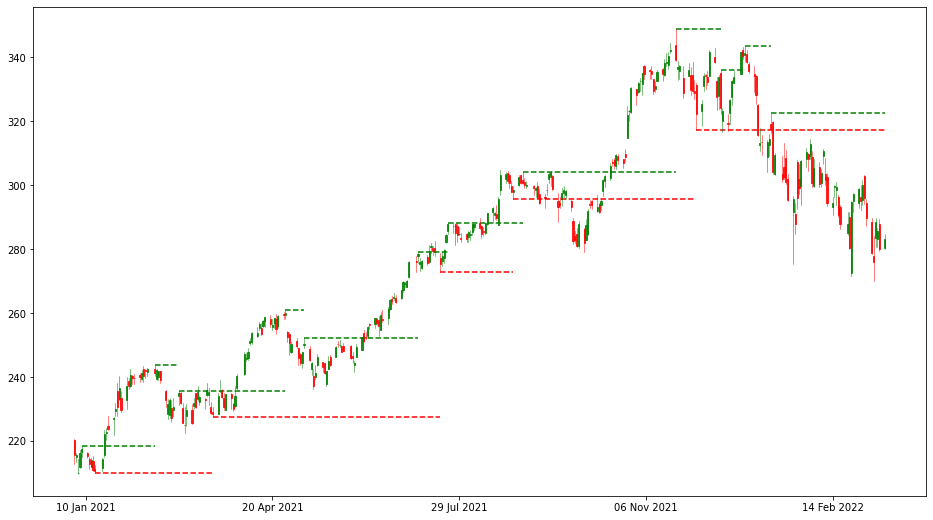

In [94]:
levels_1 = detect_level_method_1(df)
plot_all(levels_1, df)

#method 2: window shifting method

In [95]:
#method 2: window shifting method
def detect_level_method_2(df):
  levels = []
  max_list = []
  min_list = []
  for i in range(5, len(df)-5):
      high_range = df['High'][i-5:i+4]
      current_max = high_range.max()
      if current_max not in max_list:
          max_list = []
      max_list.append(current_max)
      if len(max_list) == 5 and is_far_from_level(current_max, levels, df):
          levels.append((high_range.idxmax(), current_max, "r"))
      
      low_range = df['Low'][i-5:i+5]
      current_min = low_range.min()
      if current_min not in min_list:
          min_list = []
      min_list.append(current_min)
      if len(min_list) == 5 and is_far_from_level(current_min, levels, df):
          levels.append((low_range.idxmin(), current_min, "s"))
  return levels

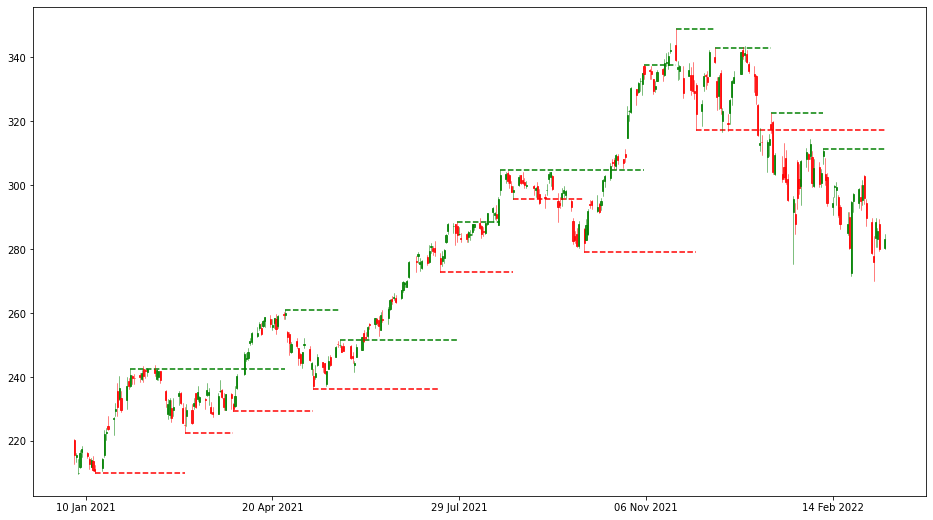

In [96]:
levels_2 = detect_level_method_2(df)
plot_all(levels_2, df)

# Поиск пробитий

In [97]:
def plot_lines(df, levels):
  df_copy = df.copy(deep=True)

  for level in iter(levels):
    start_id = level[0]
    line_value = level[1]
    line_type = level[2]
    if line_type == "r":
      df_copy.loc[start_id:, "resistance"] = line_value
    elif line_type == "s":
      df_copy.loc[start_id:, "support"] = line_value

  df_copy.loc[df_copy["Close"]>df_copy["resistance"], "sell"] = df_copy.loc[df_copy["Close"]>df_copy["resistance"], "Close"]
  df_copy.loc[df_copy["Close"]<df_copy["support"], "buy"] = df_copy.loc[df_copy["Close"]<df_copy["support"], "Close"]


  ax = df_copy[["Close"]].plot(figsize=[13,8])
  df_copy[["resistance", "support"]].plot(style = "--", ax=ax)
  df_copy[["buy"]].plot(c="green", ax=ax, style="^")
  df_copy[["sell"]].plot(c="red", ax=ax, style="*")
 
  return df_copy

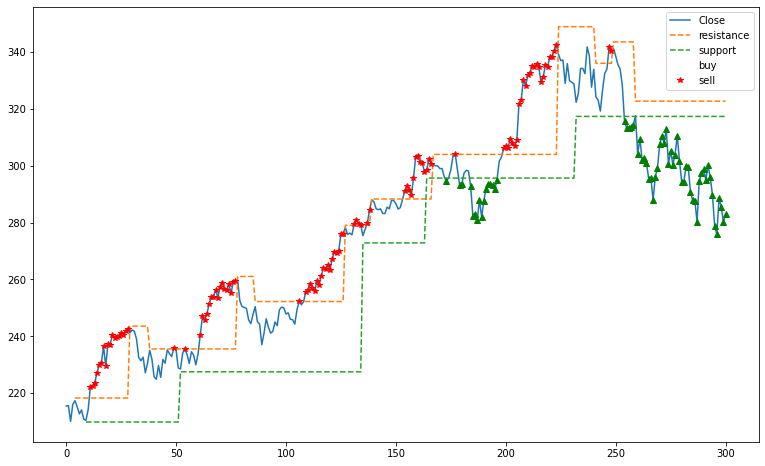

In [102]:
t = plot_lines(df, levels_1)

#Стратегия на основе пробитий

In [103]:
valid_df = t[["Date", "Close", "sell", "buy"]]
valid_df.columns = ["Date", "price", "sell_signal", "buy_signal"]
valid_df = valid_df.set_index("Date")

In [104]:
valid_df.head()

,price,sell_signal,buy_signal
Date,,,
737794.0,215.434967,NaN,NaN
737795.0,215.642776,NaN,NaN
737796.0,210.051315,NaN,NaN
737797.0,216.028748,NaN,NaN
737798.0,217.344971,NaN,NaN


# Валидация стратегии

In [105]:
money_hist_train, money_train, eq_train = validate(valid_df, start_money = 10000, verbose=2)

Денег в начале стратегии: 10000
738043.0: Покупаем 33.0  по цене 294.5608825683594, остаток средств: 279.4908752441406
738049.0: Продаём 33.0  по цене 304.033935546875, остаток средств: 10312.610748291016
738053.0: Покупаем 35.0  по цене 293.1563720703125, остаток средств: 52.137725830078125
738054.0: Покупаем 0.0  по цене 293.6544494628906, остаток средств: 52.137725830078125
738060.0: Покупаем 0.0  по цене 293.02691650390625, остаток средств: 52.137725830078125
738061.0: Покупаем 0.0  по цене 282.41827392578125, остаток средств: 52.137725830078125
738062.0: Покупаем 0.0  по цене 282.89642333984375, остаток средств: 52.137725830078125
738063.0: Покупаем 0.0  по цене 280.82452392578125, остаток средств: 52.137725830078125
738064.0: Покупаем 0.0  по цене 287.9765930175781, остаток средств: 52.137725830078125
738067.0: Покупаем 0.0  по цене 282.0098571777344, остаток средств: 52.137725830078125
738068.0: Покупаем 0.0  по цене 287.6379089355469, остаток средств: 52.137725830078125
738069.

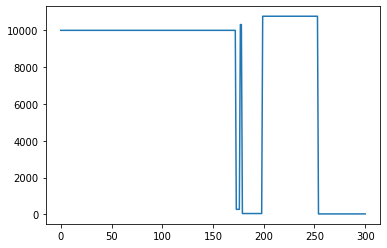

In [106]:
plt.plot(money_hist_train)